## Impor Library dan Muat Dataset

In [ ]:
# Cell 1
import pandas as pd
import numpy as np
import kagglehub
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("prepinstaprime/europe-bike-store-sales")

data = pd.read_csv(os.path.join(path, 'Sales.csv'))
df = pd.DataFrame(data.values)
df.columns = data.columns
df

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,2013-11-26,26,November,2013,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
1,2015-11-26,26,November,2015,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
2,2014-03-23,23,March,2014,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,23,45,120,1366,1035,2401
3,2016-03-23,23,March,2016,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,20,45,120,1188,900,2088
4,2014-05-15,15,May,2014,47,Adults (35-64),F,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,4,45,120,238,180,418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113031,2016-04-12,12,April,2016,41,Adults (35-64),M,United Kingdom,England,Clothing,Vests,"Classic Vest, S",3,24,64,112,72,184
113032,2014-04-02,2,April,2014,18,Youth (<25),M,Australia,Queensland,Clothing,Vests,"Classic Vest, M",22,24,64,655,528,1183
113033,2016-04-02,2,April,2016,18,Youth (<25),M,Australia,Queensland,Clothing,Vests,"Classic Vest, M",22,24,64,655,528,1183
113034,2014-03-04,4,March,2014,37,Adults (35-64),F,France,Seine (Paris),Clothing,Vests,"Classic Vest, L",24,24,64,684,576,1260


## pra-pemrosesan data dan feature engineering

In [ ]:
df_proc = df.copy()

df_proc['Date'] = pd.to_datetime(df_proc['Date'], errors='coerce')
df_proc['Month_Num'] = df_proc['Date'].dt.month
df_proc['Day_of_Week'] = df_proc['Date'].dt.dayofweek
df_proc['Day_Num'] = df_proc['Date'].dt.day

numeric_cols = ['Customer_Age', 'Order_Quantity', 'Unit_Cost', 'Unit_Price',
                'Profit', 'Cost', 'Revenue', 'Day', 'Year', 'Day_Num', 'Month_Num']
for col in numeric_cols:
    if col in df_proc.columns:
        df_proc[col] = pd.to_numeric(df_proc[col], errors='coerce')

df_proc = df_proc.dropna(subset=['Age_Group', 'Customer_Age', 'Order_Quantity', 'Unit_Price', 'Revenue', 'Date'])

y, class_names = pd.factorize(df_proc['Age_Group'])

top_n = 10
top_countries = df_proc['Country'].value_counts().nlargest(top_n).index
df_proc['Country_grp'] = df_proc['Country'].where(df_proc['Country'].isin(top_countries), other='Other')

cat_cols = [c for c in ['Customer_Gender', 'Product_Category', 'Sub_Category', 'Country_grp'] if c in df_proc.columns]
df_cat = pd.get_dummies(df_proc[cat_cols], drop_first=True)

num_features = [c for c in ['Customer_Age', 'Order_Quantity', 'Unit_Cost', 'Unit_Price',
                            'Profit', 'Cost', 'Revenue', 'Month_Num', 'Day_of_Week'] if c in df_proc.columns]
df_num = df_proc[num_features].reset_index(drop=True)

X_df = pd.concat([df_num, df_cat.reset_index(drop=True)], axis=1)

X_df = X_df.fillna(X_df.median(numeric_only=True))

X = X_df.values

print("Ukuran fitur (X):", X.shape)
print("Ukuran target (y):", y.shape)
print("Jumlah kelas target:", len(class_names))
print("Nama kelas target:", list(class_names))



Ukuran fitur (X): (113036, 33)
Ukuran target (y): (113036,)
Jumlah kelas target: 4
Nama kelas target: ['Youth (<25)', 'Adults (35-64)', 'Young Adults (25-34)', 'Seniors (64+)']


## standarisasi fitur

In [3]:
# Inisialisasi StandardScaler
scaler = StandardScaler()

# Melakukan standarisasi pada data fitur (X)
X_scaled = scaler.fit_transform(X)

X_scaled

array([[-1.53505582, -0.40804595, -0.40429793, ..., -0.32995469,
        -0.37013522, -0.72871856],
       [-1.53505582, -0.40804595, -0.40429793, ..., -0.32995469,
        -0.37013522, -0.72871856],
       [ 1.18680119,  1.16069397, -0.40429793, ..., -0.32995469,
        -0.37013522, -0.72871856],
       ...,
       [-1.62578439,  1.05611131, -0.44249134, ..., -0.32995469,
        -0.37013522, -0.72871856],
       [ 0.09805838,  1.26527663, -0.44249134, ..., -0.32995469,
        -0.37013522, -0.72871856],
       [ 0.09805838,  1.16069397, -0.44249134, ..., -0.32995469,
        -0.37013522, -0.72871856]], shape=(113036, 33))

## membagi data menjadi data latih dan data uji

In [ ]:
# Membagi data dengan perbandingan 80% data latih dan 20% data uji
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

print('Ukuran data latih (X_train):', X_train.shape)
print('Ukuran data uji (X_test):', X_test.shape)



Ukuran data latih (X_train): (90428, 33)
Ukuran data uji (X_test): (22608, 33)
Dataset telah dibagi menjadi 80% data latih dan 20% data uji: 90428 sampel untuk pelatihan dan 22608 sampel untuk pengujian, masing-masing dengan 33 fitur. Target memiliki 4 kelas (Youth (<25), Adults (35-64), Young Adults (25-34), Seniors (64+)).


## menemukan nilai K optimal dengan metode elbow

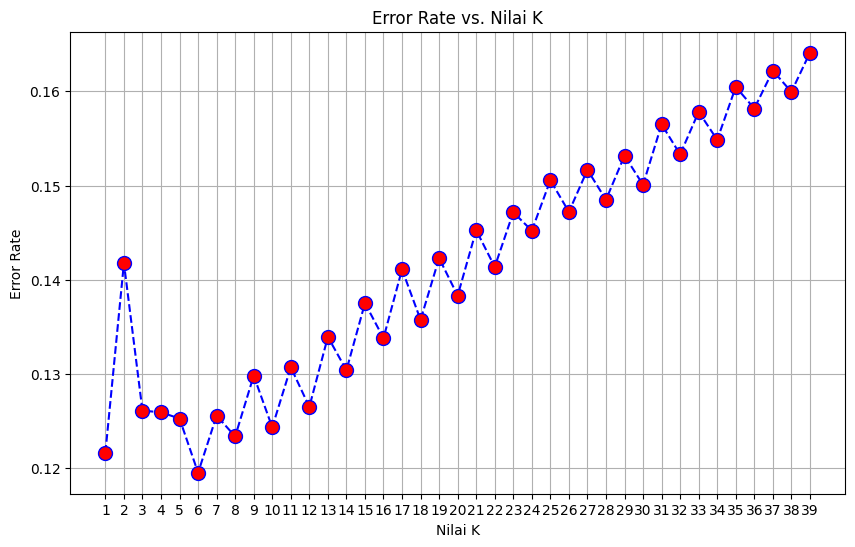

In [8]:
# Cell 5 (Perbaikan)
error_rate = []

# Tentukan jangkauan K yang valid: dari 1 hingga jumlah data latih
# Kita tidak bisa mencari K lebih banyak dari jumlah data yang kita punya
jangkauan_k = range(1, 40) # len(X_train) akan menghasilkan 6, jadi range-nya 1-5

# Melakukan iterasi untuk nilai K dalam jangkauan yang valid
for i in jangkauan_k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    # Menghitung rata-rata error (dimana prediksi tidak sama dengan data aktual)
    error_rate.append(np.mean(pred_i != y_test))

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(jangkauan_k, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. Nilai K')
plt.xlabel('Nilai K')
plt.ylabel('Error Rate')
plt.grid(True)
plt.xticks(jangkauan_k) # Memastikan sumbu-x menampilkan angka integer yang jelas
plt.show()

## Melatih model k-NN dan membuat Prediksi

In [ ]:
# Membuat model k-NN dengan nilai K yang dipilih dari grafik (misal: 5)
k_optimal = 3
knn_model = KNeighborsClassifier(n_neighbors=k_optimal)

# Melatih model menggunakan data latih
knn_model.fit(X_train, y_train)

# Membuat prediksi menggunakan data uji
y_pred = knn_model.predict(X_test)

print(f"Prediksi berhasil dibuat dengan K={k_optimal}.")



Prediksi berhasil dibuat dengan K=3.


## evaluasi performa model

In [10]:
# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy:.2f}\n")

# Menampilkan Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n")

# Menampilkan Classification Report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Akurasi Model: 0.87

Confusion Matrix:
[[ 2793     7   806     0]
 [   17 10352   819    18]
 [  464   621  6549     0]
 [    0    99     0    63]]


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      3606
           1       0.93      0.92      0.93     11206
           2       0.80      0.86      0.83      7634
           3       0.78      0.39      0.52       162

    accuracy                           0.87     22608
   macro avg       0.84      0.74      0.77     22608
weighted avg       0.88      0.87      0.87     22608

